# Climate Data Store (CDS) - Example Frontend

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of the proposed data delivering service. Example usage of the Climate Data Store (CDS) Frontend for Radiosonde data.

    Author: M. Blaschek
    Date: 06.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020

In [1]:
# check if necessary packages are install
!pip -q install numpy pandas xarray matplotlib 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')
yplevs = np.array([10,30,70,125,175,225,300,400,500,700,925])*100.

# Functionality via the CDSAPI

The backend is called via the `cdsapi` and requests the data.

The frontend returns files, which are:
1. Zip files containing CF 1.7 compliant netCDF4 files (one per station and per variable). The default name is download.zip.

A typical request should contain:
1. **statid** - the Station Identifier
    * e.g. `'11035' or ['11035','72357'] or 'all'`
2. **year** - Year
    * e.g. `1999`
3. **month** - Month
    * e.g. `02`
4. **day** - Day
    * e.g. `01, 02, ...`
5. **period** - datetime range
    * e.g. `a range '1999-01-01/1999-12-31'  for all data in 1999'
6. **pressure_level** - selection of pressure levels in hPa
    * e.g. `one level ['850'] or ['500', '850'] or no keyword for all significant levels`
7. **variable** - selection of variables 
    * e.g. `air_temperature, air_relative_humidity, air_specific_humidity, zonal_wind, meridional_wind, wind_speed, wind_direction`
8. **fbstats**  - feedback information from reanalysis
    * e.g. `obs_minus_an, obs_minus_fg, bias_estimate`
9. **country** - request all stations from a country
    * e.g. `DEU, USA, GBR, ...`
10. **bbox** - request all stations within a bounding box 

## CDSAPI Access

The CDSAPI requires a `.cdsapirc` file. Please [register](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome) at the CDS and follow the "[How-to](https://cds.climate.copernicus.eu/api-how-to)" to allow the API access.

## Example Request - One Profile

The requested data will be downloaded and unzipped into the `example_data` directory.

**Update: Please note that the request did hardly change from the backend-version.** Which can be found here: [Example-backend](https://github.com/MBlaschek/CEUAS/blob/master/CEUAS/public/cds-backend/Example.ipynb)

In [4]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

t0 = time.time()
plevs = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000]
# Server URL will change once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
try:
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {
                       'variable': ["air_temperature", "air_relative_humidity"],
                       'year': '2000',
                       'month':'02',
                       'day':'01',
                       'statid': '10393',
                       'pressure_level': plevs,
                       'fbstats': ["obs_minus_bg", "obs_minus_an", "bias_estimate"],
                   })
except:
    raise RuntimeError("Request failed")

r.download(target='download.zip')
#
# Check requested file
#
if os.stat('download.zip').st_size != r.content_length:
    print(r)
    raise RuntimeError("Downloaded file size does not match requested file size")
#
# Create directory
#
if not os.path.isdir('./example_data/1'):
    os.makedirs('./example_data/1',)
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/1")
    print(z.namelist())
    z.extractall(path='./example_data/1')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

2020-06-30 13:52:39,390 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-06-30 13:52:39,543 INFO Request is completed
2020-06-30 13:52:39,544 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1593517819.125548-17119-1-58a69f87-7801-46b7-b387-8a3d86fec280.zip to download.zip (65.1K)
2020-06-30 13:52:39,654 INFO Download rate 595.7K/s


Unzipping retrieved files: to ./exampla_data/1
['dest_0-20000-0-10393_air_temperature.nc', 'dest_0-20000-0-10393_relative_humidity.nc']
Time elapsed:  0.32577037811279297 s


In [5]:
# Show the new downloaded files in example_data directory
!ls -Rlh example_data/1

example_data/1:
total 72K
-rw-r--r--. 1 mblaschek users 33K Jun 30 13:52 dest_0-20000-0-10393_air_temperature.nc
-rw-r--r--. 1 mblaschek users 33K Jun 30 13:52 dest_0-20000-0-10393_relative_humidity.nc


## Retrieved files

In [7]:
import xarray as xr

In [8]:
# Open Netcdf with Xarray
tdata = xr.open_mfdataset('example_data/1/dest_*_air_temperature.nc', combine='by_coords')
tdata

<xarray.Dataset>
Dimensions:           (obs: 59, string10: 10, trajectory: 4)
Coordinates:
    lat               (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    lon               (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] dask.array<chunksize=(59,), meta=np.ndarray>
  * trajectory        (trajectory) int32 0 0 0 0
Data variables:
    bias_estimate     (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    obs_minus_an      (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    obs_minus_bg      (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    ta                (obs) float32 dask.array<chunksize=(59,), meta=np.ndarray>
    trajectory_index  (obs) int32 dask.array<chunksize=(59,), meta=np.ndarray>
    trajectory_label  (trajectory, string10) |S1 dask.array<chunksize=(4, 10), meta=np.ndarray>
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 3...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Variables

Notice that there are the following variables:
* `bias_estimate` - Reanalysis Bias estimate
* `obs_min_an` - Analysis Departures
* `obs_min_bg` - First Guess Departures
* `ta` - Observations, e.g. Air Temperature
* `trajectory_index` - unique profile identifier, where each observation belongs to
* `trajectory_label` - unique profile label, as in the CDM tables

Notice as well the Dimensions:
* `obs` - Dimension that corresponds to a record lenght (all profiles together)
* `trajectory`  - Dimension that corresponds to a number of individual profiles

and Coordinates:
* `lat` - Coordinate Information Latitude
* `lon` - Coordinate Information Longitude
* `plev` - Coordinate Information pressure
* `time` - Coordinate Information time

# Request a profile & plot

Tasks:
* One station: `11035`
* One datetime: `20000101`
* Two variables: `air_temperature, air_relative humidity`
* Notice no `pressure_level`, thus requesting significant level data.

In [10]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
t0 = time.time()
# Server URL will change once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
try:
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {
                       'variable': ["air_temperature", "air_relative_humidity"],
                       'year': '2000',
                       'month':'02',
                       'day':'01',
                       'statid':'10393',
                   })
except:
    raise RuntimeError("Request failed")
    
r.download(target='download.zip')
#
# Check requested file
#
if os.stat('download.zip').st_size != r.content_length:
    print(r)
    raise RuntimeError("Downloaded file size does not match requested file size")
#
# Create directory
#
if not os.path.isdir('./example_data/2'):
    os.makedirs('./example_data/2')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/2")
    print(z.namelist())
    z.extractall(path='./example_data/2')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

2020-06-30 13:56:06,283 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-06-30 13:56:06,476 INFO Request is queued
2020-06-30 13:56:07,512 INFO Request is running
2020-06-30 13:56:09,050 INFO Request is completed
2020-06-30 13:56:09,316 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1593518168.404673-17157-1-e369f43b-1db4-45bd-aa35-d909d7e46443.zip to download.zip (52.4K)
2020-06-30 13:56:09,429 INFO Download rate 465.5K/s


Unzipping retrieved files: to ./exampla_data/2
['dest_0-20000-0-10393_air_temperature.nc', 'dest_0-20000-0-10393_relative_humidity.nc']
Time elapsed:  3.2206015586853027 s


## Read the NetCDF to xarray

In [11]:
# In case of NetCDF error might need to run again (unknown bug)
tdata = xr.load_dataset('example_data/2/dest_0-20000-0-10393_air_temperature.nc')
rdata = xr.load_dataset('example_data/2/dest_0-20000-0-10393_relative_humidity.nc')

In [12]:
# This is the xarray representation of the NetCDF file
tdata

<xarray.Dataset>
Dimensions:           (obs: 227, string10: 10, trajectory: 4)
Coordinates:
    lat               (obs) float32 52.22 52.22 52.22 ... 52.22 52.22 52.22
    lon               (obs) float32 14.12 14.12 14.12 ... 14.12 14.12 14.12
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 4260.0 5000.0 5180.0 ... 96100.0 100000.0
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-02-01T05:00:00 ... 2000-02-01T23:00:00
  * trajectory        (trajectory) int32 0 0 0 0
Data variables:
    ta                (obs) float32 200.3 203.7 nan 205.3 ... 278.2 278.2 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
    trajectory_label  (trajectory, string10) |S1 b'0' b'0' b'0' ... b'9' b'2'
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 3...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Plot a profile

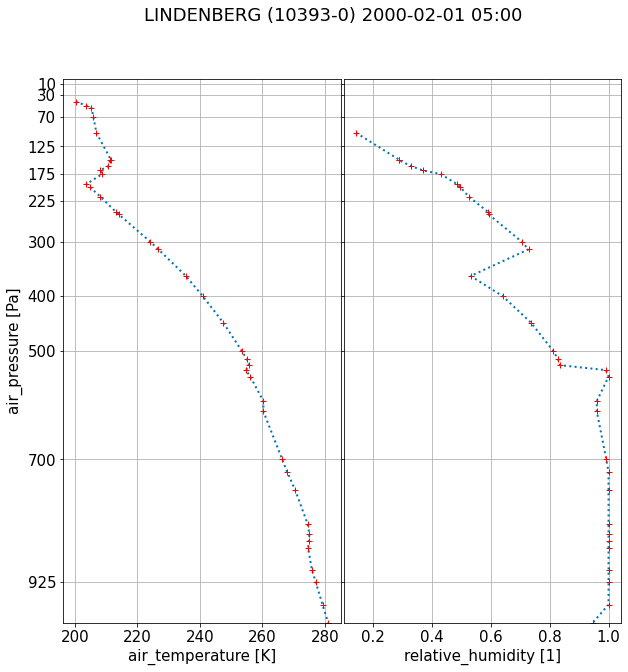

In [13]:
#
# Select first profile, change dimension to pressure, drop missing values
#
plotdata = tdata.sel(obs=tdata.trajectory_index==0).ta.swap_dims({'obs':'plev'}).to_dataset()
plotdata['hur'] = rdata.sel(obs=rdata.trajectory_index==0).hur.swap_dims({'obs':'plev'})
#
# Plotting
#
f, [ax,ay] = subplots(1,2, sharey=True, figsize=(10,10))
plotdata.ta.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ax)
plotdata.hur.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ay)
# ax.set_yscale('log')
ax.set_yticks(ticks=yplevs)
ax.set_yticklabels(map("{:.0f}".format,yplevs/100))
ax.set_ylim(100000,100)
ay.set_ylim(100000,100)
ax.grid()
ay.grid()
ay.set_ylabel('')
subplots_adjust(wspace=0.01)
f.suptitle("{} {}".format(tdata.attrs['station_name'], plotdata.time.dt.strftime("%Y-%m-%d %H:%M").item(0)),);

# Request a timeseries

Tasks:
* One Station: `11035`
* Datetime range: ` '20000101-20181231' ` 
* Two variables: `air_temperature, air_relative humidity`
* One pressure level: `85000`


In [31]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
t0 = time.time()
# Server URL will change once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
try:
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {
                       'variable': ["air_temperature", "air_relative_humidity"],
                       'date': '20000101',
                       'pressure_level': '850',
                       'statid':'10393',
                   })
except:
    raise RuntimeError("Request failed")
    
r.download(target='download.zip')
#
# Check requested file
#
if os.stat('download.zip').st_size != r.content_length:
    print(r)
    raise RuntimeError("Downloaded file size does not match requested file size")
#
# Create directory
#
if not os.path.isdir('./example_data/3'):
    os.makedirs('./example_data/3')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/3")
    print(z.namelist())
    z.extractall(path='./example_data/3')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

2020-07-01 15:22:22,788 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-01 15:22:23,012 INFO Request is queued
2020-07-01 15:22:24,047 INFO Request is failed
2020-07-01 15:22:24,048 ERROR Message: an internal error occurred processing your request
2020-07-01 15:22:24,048 ERROR Reason:  'year'
2020-07-01 15:22:24,049 ERROR   Traceback (most recent call last):
2020-07-01 15:22:24,049 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 49, in handle_request
2020-07-01 15:22:24,050 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2020-07-01 15:22:24,050 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2020-07-01 15:22:24,050 ERROR       result = proc(context, *context.args, **context.kwargs)
2020-07-01 15:22:24,051 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", li

RuntimeError: Request failed

## Read NetCDF to xarray

In [27]:
tdata = xr.load_dataset('example_data/3/dest_0-20000-0-10393_air_temperature.nc')
rdata = xr.load_dataset('example_data/3/dest_0-20000-0-10393_relative_humidity.nc')

In [28]:
# Again the representation of the NetCDF file, 
# Notice the number of trajectories (13879), this is basically the amount of profiles in the file.
tdata

<xarray.Dataset>
Dimensions:           (obs: 8, string10: 10, trajectory: 8)
Coordinates:
    lat               (obs) float32 52.22 52.22 52.22 ... 52.20965 52.20965
    lon               (obs) float32 14.12 14.12 14.12 ... 14.11996 14.11996
  * obs               (obs) int32 0 0 0 0 0 0 0 0
    plev              (obs) float32 85000.0 85000.0 85000.0 ... 85000.0 85000.0
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2018-01-01T22:45:05
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0
Data variables:
    ta                (obs) float32 265.9 266.7 268.9 ... 270.38 270.36 270.85
    trajectory_index  (obs) int32 0 1 2 3 4 5 6 7
    trajectory_label  (obs, string10) |S1 b'0' b'0' b'0' b'0' ... b'2' b'2' b'8'
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 0...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Plot a timeseries

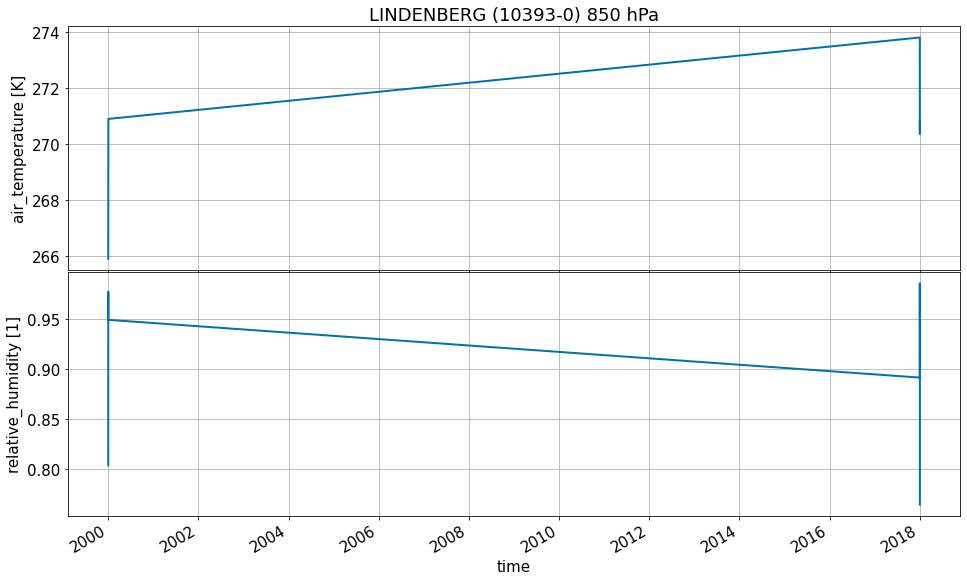

In [21]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.ta.swap_dims({'obs':'time'}).to_dataset()
plotdata['hur'] = rdata.hur.swap_dims({'obs':'time'})
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, figsize=(16,9))
plotdata.ta.dropna('time').plot(x='time', ax=ax)
plotdata.hur.dropna('time').plot(x='time', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
subplots_adjust(hspace=0.01)
ax.set_title("{} {:.0f} hPa".format(tdata.attrs['station_name'], plotdata.plev.values[0]/100));

# Request multiple Stations

Select radiosondes based on a country code:
* `GLOBE` or `ALL`
* `DEU` for Germany
* `AUT` for Austria
* `GBR` for Great Britain
* `USA` for United States of America

for further Codes and details please search at WMO's [OSCAR](https://oscar.wmo.int/surface/#/)

Tasks:
* 4 Stations: `11035,11010,11120,11240`
    - Vienna, Linz, Innsbruck and Graz. Four Stations from Austria
* One day: `20000101 - 20000101`
* Two variables: `temperature, relative humidity`
* One pressure level: `85000`

In [52]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
t0 = time.time()
# Server URL will change once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
try:

    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {
                       'variable': ["air_temperature", "air_relative_humidity"],
                       'year': '2000',
                       'month': '01',
                       'day': '01',
                       'pressure_level' : '850',
                       'country': 'DEU'
                   })
except:
    raise RuntimeError("Request failed")
    
r.download(target='download.zip')
#
# Check requested file
#
if os.stat('download.zip').st_size != r.content_length:
    print(r)
    raise RuntimeError("Downloaded file size does not match requested file size")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

2020-06-30 12:02:30,035 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-06-30 12:02:30,401 INFO Request is queued
2020-06-30 12:02:31,435 INFO Request is running
2020-06-30 12:02:35,260 INFO Request is completed
2020-06-30 12:02:35,499 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1593511352.931252-17990-1-7f1dd7bc-c0b8-4837-bd9a-d4a7678f6fde.zip to download.zip (503.6K)
2020-06-30 12:02:35,903 INFO Download rate 1.2M/s 


Unzipping retrieved files: to ./exampla_data
['dest_0-20000-0-10393_air_temperature.nc', 'dest_0-20000-0-10393_relative_humidity.nc', 'dest_0-20000-0-10200_air_temperature.nc', 'dest_0-20000-0-10200_relative_humidity.nc', 'dest_0-20000-0-10035_air_temperature.nc', 'dest_0-20000-0-10035_relative_humidity.nc', 'dest_0-20000-0-10184_air_temperature.nc', 'dest_0-20000-0-10184_relative_humidity.nc', 'dest_0-20000-0-10548_air_temperature.nc', 'dest_0-20000-0-10548_relative_humidity.nc', 'dest_0-20000-0-10739_air_temperature.nc', 'dest_0-20000-0-10739_relative_humidity.nc', 'dest_0-20000-0-10410_air_temperature.nc', 'dest_0-20000-0-10410_relative_humidity.nc', 'dest_0-20000-0-10618_air_temperature.nc', 'dest_0-20000-0-10618_relative_humidity.nc', 'dest_0-20000-0-10771_air_temperature.nc', 'dest_0-20000-0-10771_relative_humidity.nc', 'dest_0-20000-0-10868_air_temperature.nc', 'dest_0-20000-0-10868_relative_humidity.nc']
Time elapsed:  6.122261047363281 s


## Read NetCDF to xarray

In [36]:
!rm example_data/dest_0-20000-0-10393*

In [43]:
data = {}
for ifile in os.listdir('./example_data/'):
    ident = ifile.split('_')[1]
    
    if ident not in data.keys():
        data[ident] = []
    #
    # Load the NetCDF data
    #
    tmp = xr.load_dataset('./example_data/' + ifile)
    #
    # Add Sonde ID as coordinate
    #
    tmp.coords['sonde'] = ident
    #
    # Drop
    #
    tmp = tmp.drop(['trajectory_index', 'trajectory_label'])
    #
    # Use time as dimension
    #
    tmp = tmp.swap_dims({'phony_dim_0':'time'})
    data[ident].append(tmp)
#
# Merge Variables per Sonde into one Dataset
#
for ikey in data.keys():
    data[ikey] = xr.merge(data[ikey])
#
# Make a larger dataset
#
data = xr.concat(data.values(), dim='sonde')

In [45]:
data

<xarray.Dataset>
Dimensions:     (sonde: 13, time: 8)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
    lat         (sonde, time) float32 55.317 nan nan 55.32 ... 50.9 50.8994 50.9
    lon         (sonde, time) float32 -3.2 nan nan -3.2 ... 0.32 0.3169 0.32
    plev        (sonde, time) float32 85000.0 nan nan ... 85000.0 85000.0
  * sonde       (sonde) object '0-20000-0-03162' ... '0-20000-0-03882'
Data variables:
    obs         (sonde, time) float64 0.0 nan nan 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ta          (sonde, time) float32 273.35 nan nan ... 277.2 277.15 274.8
    trajectory  (sonde, time) float64 0.0 nan nan 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hur         (sonde, time) float32 nan nan nan ... 0.108502455 nan 0.9716997

## Merged Dataset

Notice that we have 4 Sondes and 4 times. This happens because the reported times are launch times. 

We can have a look at the temperature information. 
1. Vienna (11035) has soundings at 00Z and 12Z
2. Linz (11010) has one sounding at 05Z
3. Innsbruck (11120) has one sounding at 00Z
4. Graz (11240) has one sounding at 04Z

In [46]:
print(data.ta)

<xarray.DataArray 'ta' (sonde: 13, time: 8)>
array([[273.35,    nan,    nan, 275.6 , 275.55,    nan,    nan, 272.9 ],
       [   nan,    nan,    nan,    nan, 278.8 ,    nan,    nan,    nan],
       [   nan,    nan,    nan,    nan,    nan,    nan,    nan, 278.6 ],
       [291.15,    nan,    nan, 290.55, 290.55,    nan,    nan,    nan],
       [   nan,    nan,    nan, 282.  , 281.95,    nan,    nan,    nan],
       [   nan,    nan,    nan, 263.7 , 263.65,    nan,    nan,    nan],
       [275.55, 275.2 , 275.15, 277.4 , 277.35, 278.4 , 278.35, 280.6 ],
       [   nan, 278.6 , 278.55, 278.2 , 278.15, 277.8 , 277.75, 278.8 ],
       [269.45, 270.9 , 270.85, 273.2 , 273.15, 272.9 , 272.85, 272.3 ],
       [270.65, 269.3 , 269.25, 273.6 , 273.55, 270.1 , 270.05, 270.7 ],
       [277.35, 278.8 , 278.75, 279.6 , 279.55, 279.8 , 279.75, 279.2 ],
       [275.75, 277.8 , 277.75, 278.4 , 278.35, 279.6 , 279.55, 278.4 ],
       [   nan, 276.4 , 276.35, 276.6 , 276.55, 277.2 , 277.15, 274.8 ]],
     

## Preparing plotdata

In order to have a common datetime we choose here to interpolate to 06Z as a common time.
To do this be need to fill the missing information and linearly interpolate to the time:
1. `interpolate_na`, interpolate missing values, only possible for Vienna, because 04Z and 05Z lie between 00Z and 12Z.
2. `ffill`, forward fill, copies the information to other times.
3. `interp`, linearly interpolates to the wanted time 06Z.
    - Note only for Vienna the value is interpolated between 05Z and 12Z

In [47]:
plotdata = data.interpolate_na('time')  # Interpolate
plotdata

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/missing.py:346: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/missing.py:346: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/missing.py:346: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*self.dims)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/missing.py:346: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transpos

<xarray.Dataset>
Dimensions:     (sonde: 13, time: 8)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
    lon         (sonde, time) float32 -3.2 nan nan -3.2 ... 0.32 0.3169 0.32
    plev        (sonde, time) float32 85000.0 nan nan ... 85000.0 85000.0
  * sonde       (sonde) object '0-20000-0-03162' ... '0-20000-0-03882'
    lat         (sonde, time) float32 55.317 nan nan 55.32 ... 50.9 50.8994 50.9
Data variables:
    obs         (sonde, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ta          (sonde, time) float32 273.35 274.37274 ... 277.15 274.8
    trajectory  (sonde, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hur         (sonde, time) float32 nan nan nan ... 0.25236866 0.9716997

In [48]:
# reset_coords make lon, lat to variables and allows them to be filled as well, set_coords make lat,lon coordinates again, but filled with information now.
plotdata = plotdata.reset_coords(['lon', 'lat']).ffill('time').bfill('time').set_coords(['lon', 'lat'])
plotdata

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/missing.py:410: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/missing.py:427: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)


<xarray.Dataset>
Dimensions:     (sonde: 13, time: 8)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
  * sonde       (sonde) object '0-20000-0-03162' ... '0-20000-0-03882'
    plev        (sonde, time) float32 85000.0 nan nan ... 85000.0 85000.0
    lon         (sonde, time) float32 -3.2 -3.2 -3.2 -3.2 ... 0.32 0.3169 0.32
    lat         (sonde, time) float32 55.317 55.317 55.317 ... 50.9 50.8994 50.9
Data variables:
    obs         (sonde, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ta          (sonde, time) float32 273.35 274.37274 ... 277.15 274.8
    trajectory  (sonde, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hur         (sonde, time) float32 0.13761981 0.13761981 ... 0.9716997

In [49]:
plotdata = plotdata.interp(time='2000-01-01 06:00:00')
plotdata

<xarray.Dataset>
Dimensions:     (sonde: 13)
Coordinates:
  * sonde       (sonde) object '0-20000-0-03162' ... '0-20000-0-03882'
    plev        (sonde) float64 nan nan nan nan ... 8.5e+04 8.5e+04 8.5e+04
    lon         (sonde) float64 -3.2 -0.52 -1.58 72.4 ... -5.327 -1.251 0.3169
    lat         (sonde) float64 55.32 53.17 51.75 -7.3 ... 50.22 53.01 50.9
    time        datetime64[ns] 2000-01-01T06:00:00
Data variables:
    obs         (sonde) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ta          (sonde) float64 274.6 278.8 278.6 290.8 ... 278.8 277.8 276.4
    trajectory  (sonde) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    hur         (sonde) float64 0.1376 0.04025 0.1577 ... 0.1469 0.03076 0.9123

## Plot a map

In [50]:
# Cartopy can not easily be installed on Colab
import cartopy.crs as ccrs
import cartopy as cpy

/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


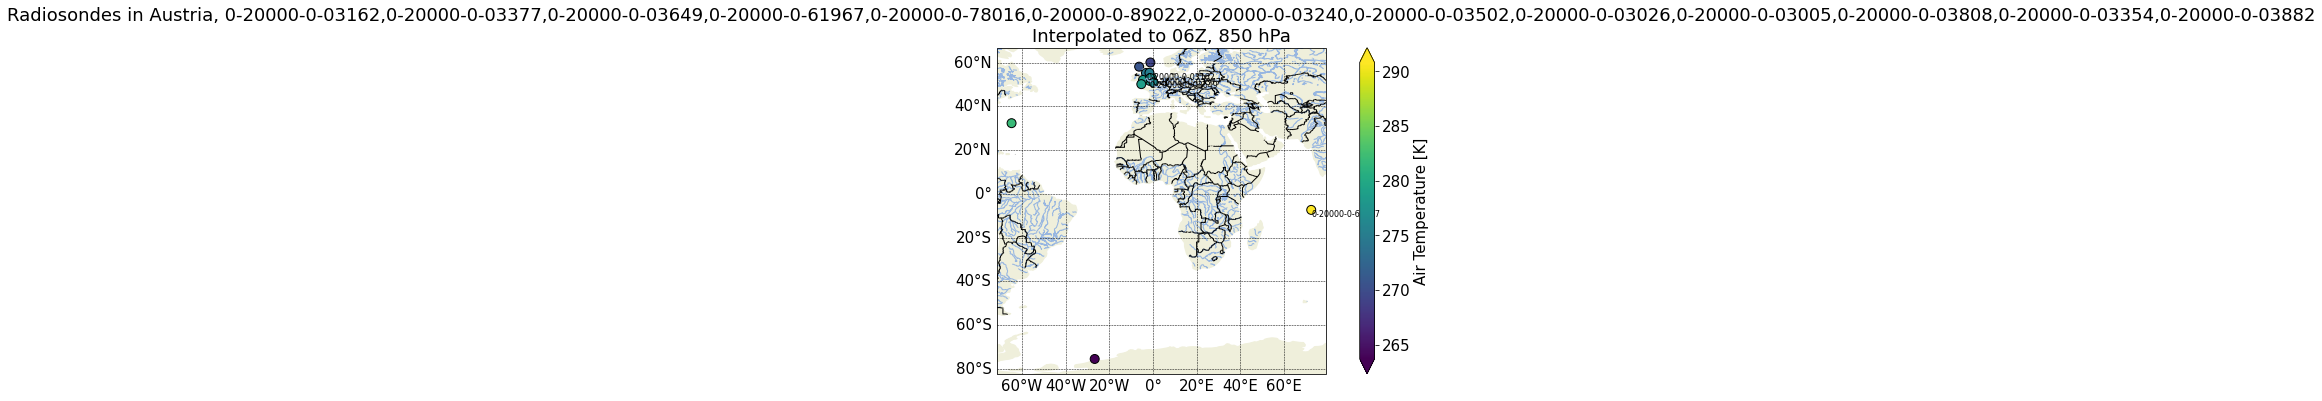

In [51]:
#
# Define the Plot
#
ax = plt.subplot(projection=ccrs.PlateCarree());
#
# Add Metainformation
#
ax.add_feature(cpy.feature.LAND, zorder=0)
ax.add_feature(cpy.feature.LAKES.with_scale('10m'), zorder=0)
ax.add_feature(cpy.feature.RIVERS.with_scale('10m'), zorder=1)
ax.add_feature(cpy.feature.BORDERS.with_scale('10m'), zorder=1)
#
# Plot the Values
#
cs = ax.scatter(plotdata.lon.values, plotdata.lat.values, 
                s=80,
                c=plotdata.ta.values,
                edgecolor='k',
                transform=ccrs.PlateCarree());
#
# Colorbar
#
cb = plt.colorbar(cs, ax=ax, extend='both')
cb.set_label("Air Temperature [K]")
#ax.set_extent([9.8,17.2,46,49.1])   # set the extent of the map
#
# Add Labels
#
lloffset = [0.1]*4
for i, j, l, k in zip(plotdata.lon.values, plotdata.lat.values, plotdata.sonde.values, lloffset):
    ax.text(i + k, j, "{}".format(l), horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=True)

ax.set_title("Radiosondes in Austria, " + ",".join(plotdata.sonde.values) + "\nInterpolated to 06Z, 850 hPa");
#
# Gird lines
#
gl = ax.gridlines(draw_labels=True, xlocs=None, ylocs=None,
                  linewidth=0.5, linestyle='--', color='k')
gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Request a timeseries and convert to cube


Tasks:
* One Station: `11035`
* Datetime range: `20000101 - 20181231`
* One variables: `temperature`
* Background Departures: `obs_minus_bg, obs_minus_an, bias_estimate`
* Standard pressure levels (#16)


In [45]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
t0 = time.time()
# Server URL will change once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
try:
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {
                       'variable': ['air_temperature'],
                       'date': ['20000101-20180101'],
                       'pressure_level': ['1000', '2000', '3000', '5000', '7000', '10000', '15000', '20000', '25000', '30000', '40000', '50000', '70000', '85000', '92500', '100000'] ,
                       'statid': '10393',
                       'fbstats': ['obs_minus_bg', 'obs_minus_an', 'bias_estimate']
                   })
except:
    raise RuntimeError("Request failed")
    
r.download(target='download.zip')
#
# Check requested file
#
if os.stat('download.zip').st_size != r.content_length:
    print(r)
    raise RuntimeError("Downloaded file size does not match requested file size")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
try:
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data")
    print(z.namelist())
    z.extractall(path='./example_data')
    z.close()
except:
    print(r.text)
    print("Error in request")
print("Time elapsed: ", time.time()-t0, "s")

2020-06-29 13:54:49,051 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-06-29 13:54:49,250 INFO Request is queued
2020-06-29 13:54:50,283 INFO Request is running
2020-06-29 13:55:38,813 INFO Request is completed
2020-06-29 13:55:38,971 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1593431735.9661758-4978-1-6d64ab5f-e6c0-47eb-a051-cb1ac64c4a27.zip to download.zip (7.2M)
2020-06-29 13:55:39,588 INFO Download rate 11.7M/s  


Unzipping retrieved files: to ./exampla_data
['dest_0-20000-0-10393_air_temperature.nc']
Time elapsed:  50.59716033935547 s


## Conversion Function from ragged array to cube

This function can also be found here: [cds-backend](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend/code)

In [46]:
sys.path.append('../cds-backend/code/')
from read_to_cube import read_ragged_array_to_cube

## Read NetCDF to xarray

In [47]:
tdata = xr.load_dataset('example_data/dest_0-20000-0-10393_air_temperature.nc')

In [48]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 407816, trajectory: 26344)
Coordinates:
    lat               (obs) float32 52.22 52.22 52.22 ... 52.20965 52.20965
    lon               (obs) float32 14.12 14.12 14.12 ... 14.11996 14.11996
    plev              (obs) float32 2000.0 3000.0 5000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2018-01-01T22:45:05
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 -0.08317048 -0.048345093 ... 0.09 nan
    obs_minus_an      (obs) float32 0.29701728 0.59811723 ... 0.11381069 nan
    obs_minus_bg      (obs) float32 0.7331748 0.49588463 ... 0.36432457 nan
    ta                (obs) float32 201.7 203.1 207.1 ... 270.85 276.95 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 26343 26343 26343 26343 26343
    trajectory_label  (trajectory) |S10 b'0000011865' ... b'0000038228'
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/

## Read NetCDF to xarray cube

In [49]:
cube = read_ragged_array_to_cube('example_data/dest_0-20000-0-10393_air_temperature.nc')

2020-06-29 13:57:53,107 - read_to_cube | read_ragged_array_to_cube - WARNING - non standard pressure levels problem
2020-06-29 13:57:53,107 WARNING non standard pressure levels problem
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/variable.py:1575: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


In [50]:
cube

<xarray.Dataset>
Dimensions:        (hour: 2, plev: 16, time: 6568)
Coordinates:
  * hour           (hour) int64 0 12
  * plev           (plev) int64 10 20 30 50 70 100 ... 400 500 700 850 925 1000
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2018-01-01
Data variables:
    bias_estimate  (hour, plev, time) float32 -0.03689436 nan nan ... nan nan
    lat            (time) float32 52.22 52.220005 52.22 ... 52.20965 52.20965
    lon            (time) float32 14.12 14.119999 14.12 ... 14.11996 14.11996
    obs            (hour, plev, time) float32 0.0 nan 0.0 nan ... 0.0 0.0 0.0
    obs_minus_an   (hour, plev, time) float32 0.7023793 nan nan ... nan nan nan
    obs_minus_bg   (hour, plev, time) float32 1.3548439 nan nan ... nan nan nan
    ta             (hour, plev, time) float32 202.3 nan nan nan ... nan nan nan
Attributes:
    Conventions:   CF-1.7
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 2...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/
    primary_id:    0-20000-0-10393
    source:        radiosonde
    station_name:  LINDENBERG (10393-0)

## Plot a timeseries

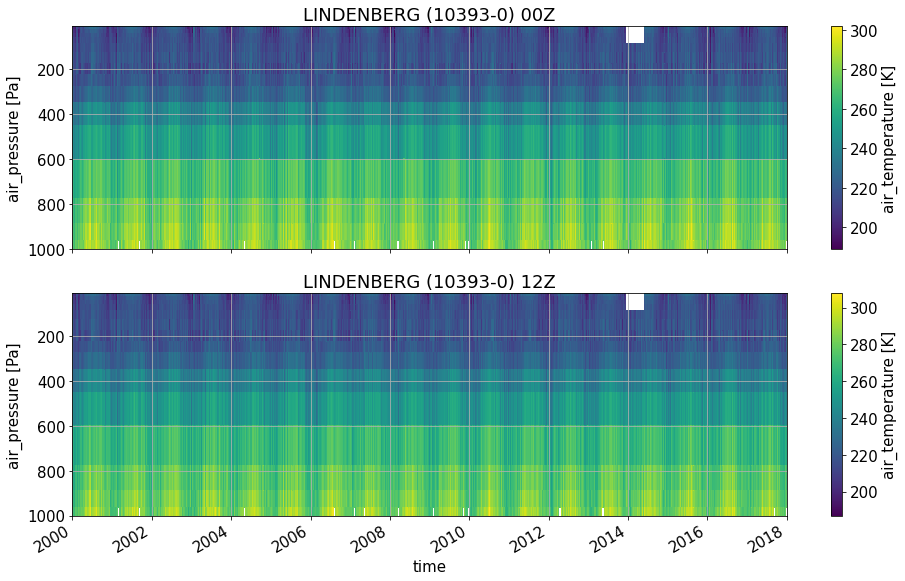

In [51]:
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
cube.sel(hour=0).ta.plot(x='time', y='plev', ax=ax)
cube.sel(hour=12).ta.plot(x='time', y='plev', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
ax.set_ylim(1000,10)
ax.set_title("{} {:02d}Z".format(cube.attrs['station_name'], 0));
ay.set_title("{} {:02d}Z".format(cube.attrs['station_name'], 12));

## Plot a profile

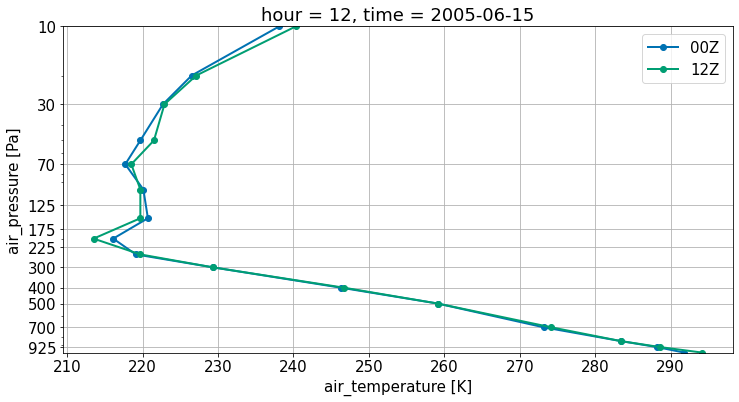

In [53]:
cube.sel(hour=0, time='2005-06-15').ta.plot(y='plev', marker='o', label='00Z')
cube.sel(hour=12, time='2005-06-15').ta.plot(y='plev', marker='o', label='12Z')
ylim(1000,10)
grid()
legend()
yscale('log')
yticks(ticks=yplevs/100, labels=map("{:.0f}".format,yplevs/100));